# Assignment 1: Decision Trees

**Please do not consult external resources for this assignment.**

Decision trees have been well-explored in the field of machine
learning. However, we expect you to provide your opinions and ideas on
how decision trees can be used to model human learning.

The required reading for this assignment is **Witten, I. H., et al. (2017). Data mining: Practical machine learning tools and techniques. Amsterdam: Elsevier. (pp. 105-113, 75-78)**. 

Optional readings:

* More technical: *Duda, R. O., et al. (2001). Pattern recognition (2nd ed.). New York: Wiley. (chap. 6)*
* Familiar if you’ve taken AI: *Russell, R., & Norvig, P. (2021) Artificial intelligence: A modern approach (4th ed.). Prentice-Hall. (chap 19, pp. 656-665)*
* Classic treatment: *Mitchell, T. M. (1997). Machine learning. McGraw-Hill. (chap. 3, pp. 52-60)*

These readings are available on Canvas under Files.

In this assignment, we are going to use the [ID3
Algorithm](https://en.wikipedia.org/wiki/ID3_algorithm) to induce a
decision tree from the classic dataset in [Quinlan,
1986](https://link.springer.com/content/pdf/10.1007%2FBF00116251.pdf).

Please download quinlan-1986.csv (found in the files directory) and
store it in your local directory.

![](static/quinlan-1986-dataset.png)

**Some of the code will be filled in for you, and in other places
pseudo code will be provided. As a part of this assignment, please
fill in the pseudocode. At the end of this notebook, you'll have a
generated decision tree. In addition, answer the questions listed at
the end of the assignment**



## Programming notes

This assignment will require the use of Python, and the numpy and
pandas libraries. Please refer to the following tutorials if you are
not familiar with them.

* [Python, if you know another programming language](https://learnxinyminutes.com/docs/python/)
* [Python, if you are new to programming](https://www.codecademy.com/learn/learn-python-3)
* [Numpy](https://scipy-lectures.org/intro/numpy/index.html)
* [Pandas](https://pandas.pydata.org/docs/getting_started/intro_tutorials/index.html)

## Dependencies and library.

Please ensure that you have `pandas` and `numpy` installed. If not,
please run the following lines to install them.

In [45]:
!pip3 install numpy
!pip3 install pandas

Let's import the modules

In [46]:
import pandas as pd
import numpy as np

## Loading & Preprocessing

Next, we load the dataset and separate the class (outcome) data from
the rest of the dataset for implementation purposes.

In [47]:
d = pd.read_csv("files/quinlan-1986.csv")
class_ = d["class"]
training_data = d.drop("class", axis=1)

## ID3 Algorithm Functions

ID3 needs to know if splitting a decision tree perfectly partitions
the input. For that reason, we define a function to check whether a
series of class values has only one unique value.


In [48]:
def is_pure(class_series):
    return len(np.unique(class_series)) == 1

ID3 utilizes the metric of information gain to determine the best
features to utilize for split the data at each node of the decision
tree. Information gain is calculated using entropy, in which entropy
is a measure of impurity and nonhomogeneity in the dataset. For
example, entropy is 0 if all datapoints in a dataset belong to a
single class.

**Please complete the `entropy()` and `information_gain()` functions
using the following equations.** Do not worry about computational
efficiency, just make sure you get the logic right.


### Entropy

The following equation describes how to calculate entropy for a dataset with
$c$ classes.

$$E(S) = \sum_{i=1}^{c} -p_{i}\log_{2}p_{i}$$

Utilize the above equation to implement the `entropy()` function. The
function takes in as input `sample_counts`, which is an array
containing the total number of samples associated with each class.

For example, if there are 4 Ns and 5 Ps, then `sample_count` would be `[4, 5]`.

The function should return a number. Note that log(0) is not
mathematically defined, use the value 0 in this case.

**Test cases**

* `entropy(np.array([1, 0, 0, 0]))` == 0
* `entropy(np.array([1, 1, 0, 0]))` == 1
* `entropy(np.array([1, 1, 0, 10]))` ~ 0.8167


In [61]:
def entropy(sample_counts):
    total_samples = np.sum(sample_counts)
    probabilities = sample_counts / total_samples
    probabilities = probabilities[probabilities > 0]
    entropy = -np.sum([pi * np.log2(pi) for pi in probabilities])
    
    return entropy

### Information Gain

`information_gain()` takes in as input a DataFrame with `cases` (*S*), a
vector with `classes` for the cases, and the `column_name` (*A*) that
we would like to determine the *gain* of splitting on:

Calculate the information gain using the following equation:

$$\text{Gain}(S,A) = \text{Entropy}(S) - \sum_{v\in \text{Values}(A)} \frac{|S_{v}|}{|S|} \text{Entropy}(S_{v})$$

where

* $\text{Entropy}(S)$ calculates the entropy across the entire sample S,
* $\text{Values}(A)$ is the set of all possible values for an
  attribute $A$, and
* $S_{v}$ is the subset of $S$ for which attribute $A$ has value $v$.

You may find these functions useful:

* [`Series.value_counts()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html)
* [`pd.crosstab()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html)

The function should return the gain value (number) for splitting `cases` on
`column_name`, using the `entropy()` function you defined earlier.

**Test cases**

The first four splits for these columns should have these values (from the slides)

* outlook == `0.24674981977443933`
* temperature == `0.02922256565895487`
* humidity == `0.15183550136234159`
* windy == `0.04812703040826949`

In [63]:
def information_gain(cases, classes, column_name):
    
    total_entropy = entropy(classes.value_counts().values)
    values, counts = np.unique(cases[column_name], return_counts=True)
    weighted_sum = 0
    
    for value, count in zip(values, counts):
        subset = cases[cases[column_name] == value]
        subset_classes = classes[subset.index]
        subset_entropy = entropy(subset_classes.value_counts().values)
        weighted_sum += (count / len(cases)) * subset_entropy
    
    information_gain = total_entropy - weighted_sum

    return information_gain

## ID3 Training

Finally, we require a training loop that keeps splitting on variables (features) in the dataset, sorted by information gain, until we have a perfect tree.

In [64]:
def train_id3(node, X, y):
    # if the dataset is perfectly separated, then stop, add a leaf node
    if is_pure(y):
        node_name = y.iloc[0] # the outcome value
        node["children"].append(node_name)
    else:

        # calculate information gain for splitting on each variable.
        igs = []
        for col in X.columns:
            igs.append(information_gain(X, y, col))
        # get the feature with the max information gain
        max_index = np.argmax(igs)
        feature_name = X.columns[max_index]

        # split the dataset that feature. Now add a child node for each
        # variable of that feature, and recursively complete the
        # process.
        grouped = X.groupby(feature_name)
        children_nodes = []
        for key, subset_X in grouped:
            child_node = dict(name=f"{feature_name}={key}", children=[])
            node["children"].append(child_node)
            subset_y = y[X[feature_name] == key]
            train_id3(child_node, subset_X, subset_y)

## Generating the decision tree

The code is structured so that a Node is a dictionary with a name and
a list of children. Let's induce the decision tree.


In [65]:
node = dict(name="root", children=[])
train_id3(node, training_data, class_)


## Visualizing the decision tree

The node dictionary is populated with each node's children provided as
a list.

We can now visualize the decision tree using two ways. The first way
is to pretty print the dictionary. Another way is to use the `graphviz`
package and generate the DOT source for it to graph.

### Visualize using pretty print


In [66]:
from pprint import pp
pp(node)

{'name': 'root',
 'children': [{'name': 'outlook=overcast', 'children': ['P']},
              {'name': 'outlook=rain',
               'children': [{'name': 'windy=False', 'children': ['P']},
                            {'name': 'windy=True', 'children': ['N']}]},
              {'name': 'outlook=sunny',
               'children': [{'name': 'humidity=high', 'children': ['N']},
                            {'name': 'humidity=normal', 'children': ['P']}]}]}


### Visualize using graphviz

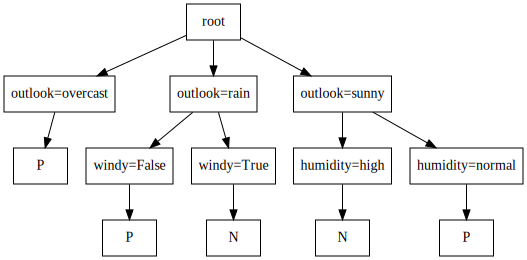

In [67]:
import random # for generating node ids
import graphviz

def make_dot_internal(node, lines, i):
    if isinstance(node, str):
        lines.append(f'{i} [label="{node}"];')
    if isinstance(node, dict):
        lines.append(f'{i} [label ="{node["name"]}"];')
        for j, child in enumerate(node["children"]):
            child_num = random.randint(0, 100000000)
            make_dot_internal(child, lines, child_num)
            lines.append(f'{i} -> {child_num};')

def make_dot(node):
    lines = []
    make_dot_internal(node, lines, 0)
    node_data = "\n".join(lines)
    return f"digraph Tree {{ node[shape=box];\n{node_data} }}"

graphviz.Source(make_dot(node))

## Questions

Respond to each question in one or two short paragraphs. Remember, we
are looking for connections to psychological plausibility in humans.

1. What does your decision tree look like? Please include the code
  you used to induce the tree, and a visualization (text or image) of
  the tree.    
    - My Decision tree generated from the "quinlan-1986.csv" dataset would typically be visualized as a series of nodes, where each node represents a decision based on a feature, leading to branches that represent different outcomes. The decision tree image is right above this cell and the code used to visualize it is also present, reused the same code as provided with the notebook.

1. Comment on the ID3 algorithm for inducing decision trees. Is the
  algorithm psychologically plausible? Which parts of the algorithm do
  you think are psychologically plausible, and which parts are not?
  What limitations do you see in decision trees? What kind of
  concepts can or can't they learn? Do you see the same limitations in
  humans?
    - The ID3 algorithm seems psychologically plausible in a few aspects such as step by step reasoning and the overall decision making process. We as humans also tend to select most informative features/attributes, that provide us the most information gain just like ID3 selects attributes. We also take things step by step where every decision might be based on the outcome of a previous decision, which is similar to how ID3 generates the decision tree, incrementally. 
    
    - The parts which i think are not psychologically plausible are the information gain calculations. Humans do not strictly make decisions based on some probability calculation that suggests this is the best decision and sometimes the decisions we make are influenced by the ones made in the past. We might also resort to heuristics and shortcuts while making our decisions and not necessarily precise calculations. Decision trees work better with hierarchical data that can be split into sequence of binary splits.
    
    - The one limitation that stands out is "over-fitting" where the model just copies the training data and is incapable of making correct decisions on a test dataset. Decision trees can over-fit on the data, this can often be the case when the tree becomes too deep. Where the noise that is introduced with a large dataset can be captured ignoring the underlying pattern. This is not how we typically generalize or make decisions, humans can often ignore noise or irrelevant details. Decision tree might also struggle with complex problems, humans on the other hand can handle such complex situations and make great judgement calls resulting in accurate decision making process.
    
    - Decision trees can learn concepts that are hierarchical, linearly seperable concepts/ideas/data. They struggle to learn non-linearly seperable concepts, they might make mistakes on continuous data without pre-processing i.e. with noise. As compared to humans, we can learn on noisy data or non-linearly seperable data as well as complex problems. Decision trees might also perform worse when we talk about making decisions that require global knowledge whereas human can perform better. Then again, there can be many factors at play in the human decision making process which might not be the case for ID3. 

1. What advantages do you see in decision trees? Do you see the same
  behavior in humans?  
      - The advantages i see in decision trees is definitely explainability, interpretability, cost effective because they tend to make greedy decisions. Decision trees are transparent while making decisions, humans can be biased. Decision trees can explain the decision process easily to humans and we can interpret a decision tree without much efforts too. Humans on the other hand might not always make decisions based on a precise probability calculation and it can be difficult to trace back and figure out how one ended at a decision. just like humans though, decision trees make decisions step by step, in a hierarchical fashion based on the most importatnt factors.

1. One advantage of a decision tree is possibly higher *explainability*, i.e., it is easy for a human to understand why the model makes the classifications it makes. Comment on how the depth of the tree might affect the explainability.  
    - A shallow tree with less number of nodes and levels might be easier to understand than a dense, multi-level tree with a lot of information and a lot of nodes. A shallow tree is easier to understand because of the small number of decisions. This reflects how humans prefer simple explanations with fewer steps to complex explanations.

2. Note that the dataset above was perfectly separable. How would you
  expand on the ID3 algorithm, or decision trees in general, to handle
  noise in the data? Would this extension make decision trees a more
  feasible model of human cognition? Why or why not?  
      - As discussed in the class, pruning can be used to handle noise in a decision tree. Pruning is a data compression technique used in Decision tree to remove the sections of the tree that are non-critical or redundant. This would make sense and bring it closer to human cognition in a way how humans learn to ignore outliers or one-off cases while forming a decision. It also alligns more with human cognition how we tend to generalise rather than memorise.

1. Note that the dataset above only contained categorical values. How
  would you expand the ID3 algorithm, or decision trees in general, to
  handle continuous values in the data? Would this extension make
  decision trees a more feasible model of human cognition? Why or why
  not?  
     - ID3 for decision tree works very well with categorical values as we have seen, to expand it to handle continuous data, one would introduce range or splits in the continuous data. Humans have ranges for temperate or number like low, medium, high and that helps one deal better with continuous data and the same can be introduced for decision trees.


## Credits

Equations are referenced from Chapter 3: Decision Tree Learning from
Mitchell, T. M. (1997).

## Submission Guidelines

Please submit this Jupyter notebook including your code and your
answers to the questions to Assignment 1 on Canvas.

The code should not depend on any system specific configuration.